<a href="https://colab.research.google.com/github/JYHYL/EART60702-Group3/blob/LSTM_prediction/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [2]:
df = pd.read_csv('https://raw.github.com/JYHYL/EART60702-Group3/main/DataSet/full_dataset.csv')
df

,date,year,month,TREFMXAV_U,FLNS,FSNS,PRECT,PRSN,QBOT,TREFHT,UBOT,VBOT,lat,lon,model
0,2006-01-01,2006,1,9.625855,41.925180,25.926952,4.663135e-09,4.781004e-17,0.004769,279.14288,3.878579,1.394184,53.246075,357.500000,3
1,2006-01-02,2006,1,11.321136,8.905806,10.946910,8.046593e-08,1.295726e-16,0.006271,281.14865,1.788157,3.821703,53.246075,357.500000,3
2,2006-01-03,2006,1,11.137970,16.511415,6.405902,2.910936e-09,4.094447e-16,0.005782,281.22380,0.804845,-2.299140,53.246075,357.500000,3
3,2006-01-04,2006,1,8.971100,29.948362,9.315041,7.432505e-11,0.000000e+00,0.004277,278.39767,-1.100267,-1.258029,53.246075,357.500000,3
4,2006-01-05,2006,1,7.740906,19.064156,7.941241,6.894238e-12,0.000000e+00,0.003990,278.06378,-0.706321,-0.938421,53.246075,357.500000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165138,2080-07-15,2080,7,22.155365,NaN,215.390100,4.232548e-13,NaN,NaN,NaN,NaN,NaN,53.248180,-2.502111,85
165139,2080-08-15,2080,8,24.427490,NaN,197.854190,1.110259e-13,NaN,NaN,NaN,NaN,NaN,53.248180,-2.502111,85
165140,2080-09-15,2080,9,22.779205,NaN,147.282270,7.228998e-14,NaN,NaN,NaN,NaN,NaN,53.248180,-2.502111,85
165141,2080-10-15,2080,10,19.056060,NaN,74.600730,2.394742e-13,NaN,NaN,NaN,NaN,NaN,53.248180,-2.502111,85


## Separate Application of LSTM to the 6 MME Datasets

**Methodology**

The daily climate data were chronologically divided into training, validation, and testing subsets. Specifically, the training set spans from January 1, 2006 to December 31, 2040, the validation set from January 1, 2041 to December 31, 2049, and the testing set from January 1, 2050 to December 30, 2080. The input sequence length was set to 7 days, meaning each training sample consists of a rolling 7-day window of meteorological variables used to predict the target variable on the 8th day.

The model architecture employed a single-layer Long Short-Term Memory (LSTM) network implemented using Keras. The network consists of one LSTM layer with 20 units and ReLU activation, followed by a fully connected dense output layer for regression. The model was compiled with the mean squared error (MSE) as the loss function and Adam as the optimizer. Training was conducted for 20 epochs, with validation data used to monitor overfitting and ensure generalizability.

After each training iteration, the model was evaluated on the test set. Predicted outputs and ground truth values were inverse-transformed from the normalized scale. In addition, to assess model convergence, both training and validation loss values were recorded and plotted throughout the training process.

All prediction results—including those on the training and test sets—were saved in .csv format within the LSTM_MME_prediction/ directory, containing columns for date, actual value, and predicted value. The training loss curves were saved as .png images in the LSTM_MME_loss_curve/ directory, facilitating further performance comparison and visual analysis.



In [3]:
# Ensure the date column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Parameter configuration
target_variable = 'TREFMXAV_U'
feature_variables = ['FLNS', 'FSNS', 'PRECT', 'PRSN', 'QBOT', 'TREFHT', 'UBOT', 'VBOT']
sequence_length = 7
rmse_results = {}

# Create directories for saving results (if they don’t exist)
prediction_dir = 'LSTM_MME_prediction'
loss_dir = 'LSTM_MME_loss_curve'
os.makedirs(prediction_dir, exist_ok=True)
os.makedirs(loss_dir, exist_ok=True)

# Function to create sequences with time index
def create_sequences(data, feature_cols, target_col, seq_len):
    X, y, index = [], [], []
    f_data = data[feature_cols].values
    t_data = data[target_col].values
    time_index = data.index
    for i in range(len(data) - seq_len):
        X.append(f_data[i:i+seq_len])
        y.append(t_data[i+seq_len])
        index.append(time_index[i+seq_len])
    return np.array(X), np.array(y), index

# Loop through model IDs 3–8
for model_id in range(3, 9):
    print(f"\nProcessing model {model_id}...")

    # Copy subset data (do not modify the original df)
    df_model = df[df['model'] == model_id].copy()
    df_model = df_model[['date'] + feature_variables + [target_variable]].dropna()
    df_model = df_model.sort_values('date').set_index('date')

    # Feature and target scaling
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()
    features_scaled = pd.DataFrame(feature_scaler.fit_transform(df_model[feature_variables]),
                                   columns=feature_variables, index=df_model.index)
    target_scaled = pd.DataFrame(target_scaler.fit_transform(df_model[[target_variable]]),
                                 columns=[target_variable], index=df_model.index)
    df_scaled = pd.concat([features_scaled, target_scaled], axis=1)

    # Dataset split by time
    train_df = df_scaled.loc['2006-01-01':'2040-12-31']
    val_df = df_scaled.loc['2041-01-01':'2049-12-31']
    test_df = df_scaled.loc['2050-01-01':'2080-12-31']

    # Create sequences
    X_train, y_train, idx_train = create_sequences(train_df, feature_variables, target_variable, sequence_length)
    X_val, y_val, _ = create_sequences(val_df, feature_variables, target_variable, sequence_length)
    X_test, y_test, idx_test = create_sequences(test_df, feature_variables, target_variable, sequence_length)

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(20, activation='relu', input_shape=(sequence_length, X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), verbose=0)

    # Evaluate on the test set
    y_pred = model.predict(X_test)
    y_pred_rescaled = target_scaler.inverse_transform(y_pred)
    y_test_rescaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    rmse_results[f'Model_{model_id}'] = rmse
    print(f"Model {model_id} - Test RMSE: {rmse:.3f}")

    # Save the loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Model {model_id} - Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(False)
    plt.tight_layout()
    loss_path = os.path.join(loss_dir, f'model_{model_id}_loss_curve.png')
    plt.savefig(loss_path)
    plt.close()

    # Save prediction results (training + testing)
    def save_predictions(X, y, idx, label):
        y_pred = model.predict(X)
        y_pred_rescaled = target_scaler.inverse_transform(y_pred)
        y_true_rescaled = target_scaler.inverse_transform(y.reshape(-1, 1))
        df_out = pd.DataFrame({
            'date': idx,
            'Actual': y_true_rescaled.flatten(),
            'Predicted': y_pred_rescaled.flatten()
        })
        output_path = os.path.join(prediction_dir, f'model_{model_id}_{label}_predictions.csv')
        df_out.to_csv(output_path, index=False)

    save_predictions(X_train, y_train, idx_train, 'train')
    save_predictions(X_test, y_test, idx_test, 'test')


Processing model 3...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Model 3 - Test RMSE: 2.077
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Processing model 4...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Model 4 - Test RMSE: 1.879
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Processing model 5...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model 5 - Test RMSE: 1.852
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Processing model 6...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model 6 - Test RMSE: 2.090
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Processing model 7...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model 7 - Test RMSE: 1.937
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Processing model 8...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model 8 - Test RMSE: 1.956
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [4]:
rmse_results

{'Model_3': np.float64(2.076999421480076),
 'Model_4': np.float64(1.8786814891068944),
 'Model_5': np.float64(1.8517782008591057),
 'Model_6': np.float64(2.0895410486105708),
 'Model_7': np.float64(1.9366286470557537),
 'Model_8': np.float64(1.9562372671857742)}

**Visualization of Loss Function Curves**

Displaying: model_3_loss_curve.png


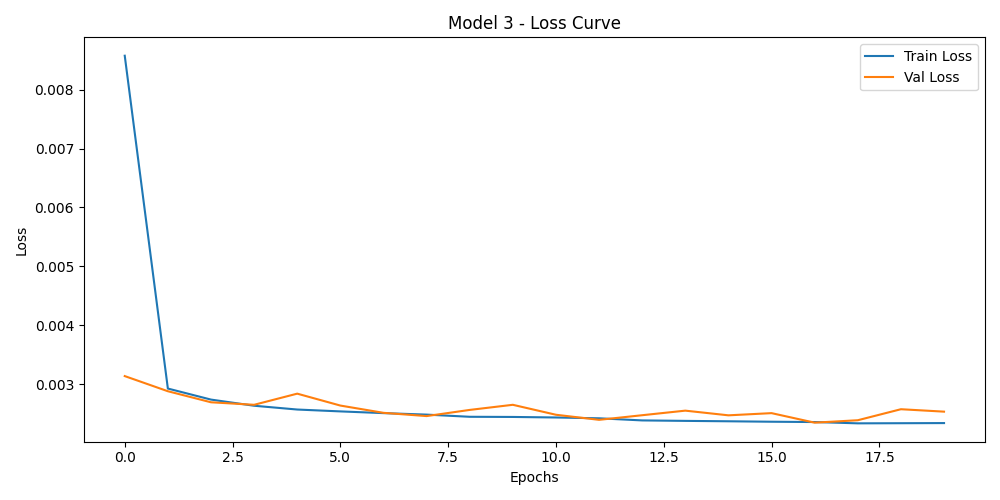

Displaying: model_4_loss_curve.png


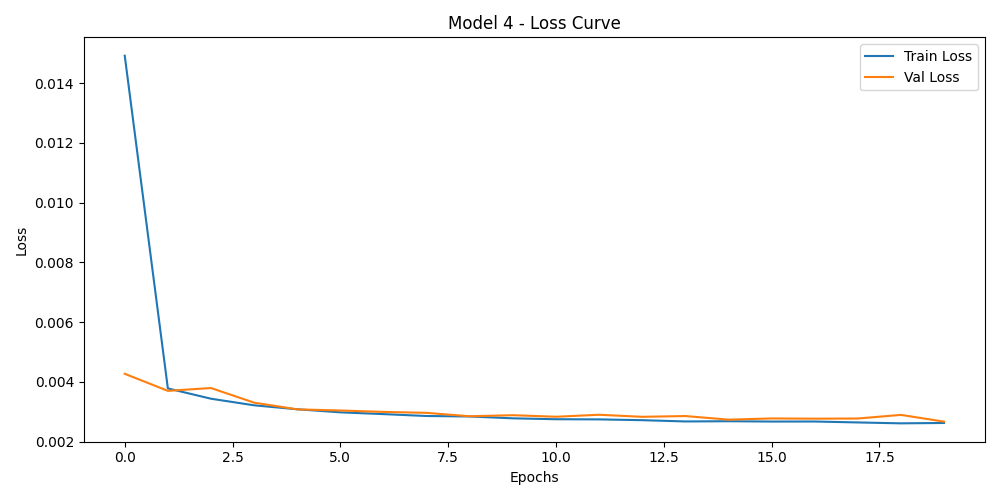

Displaying: model_5_loss_curve.png


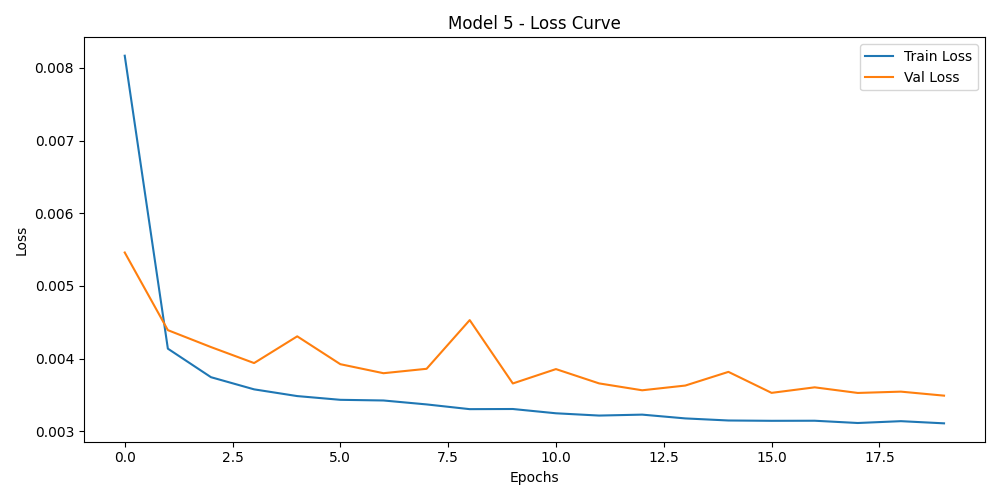

Displaying: model_6_loss_curve.png


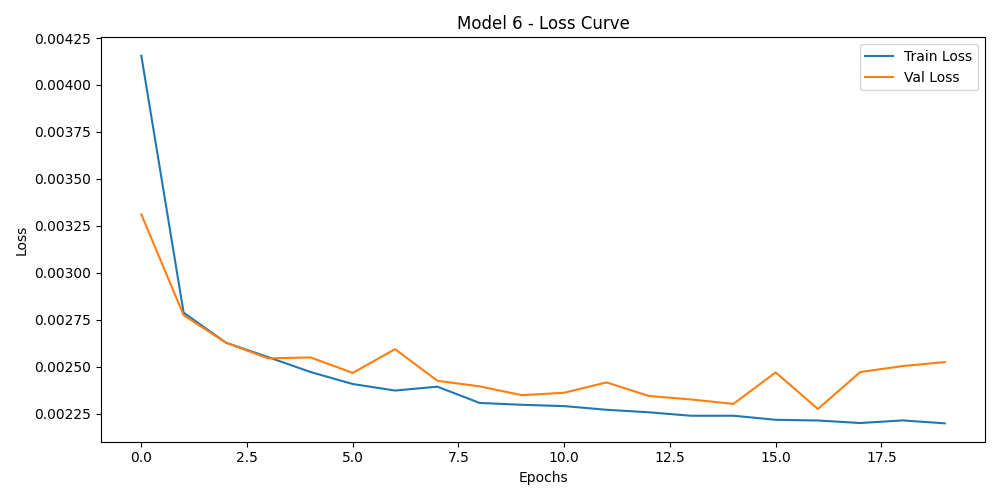

Displaying: model_7_loss_curve.png


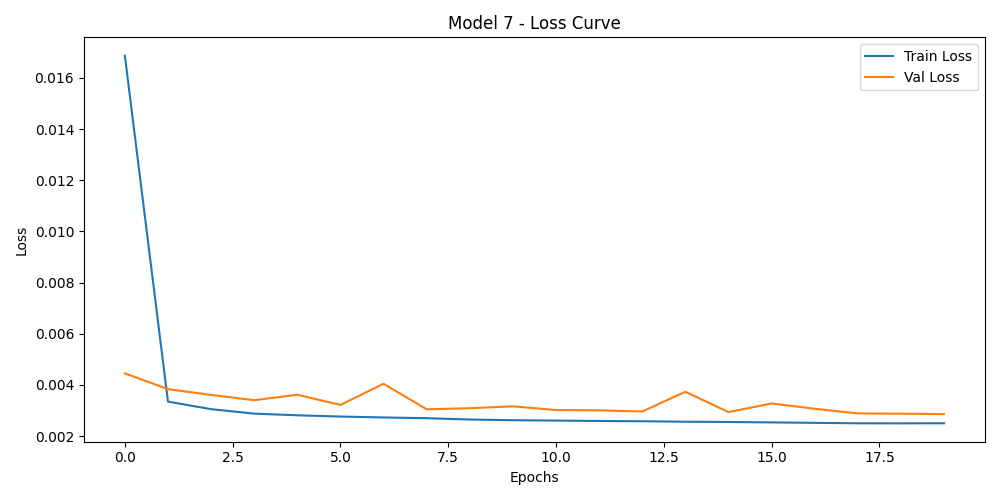

Displaying: model_8_loss_curve.png


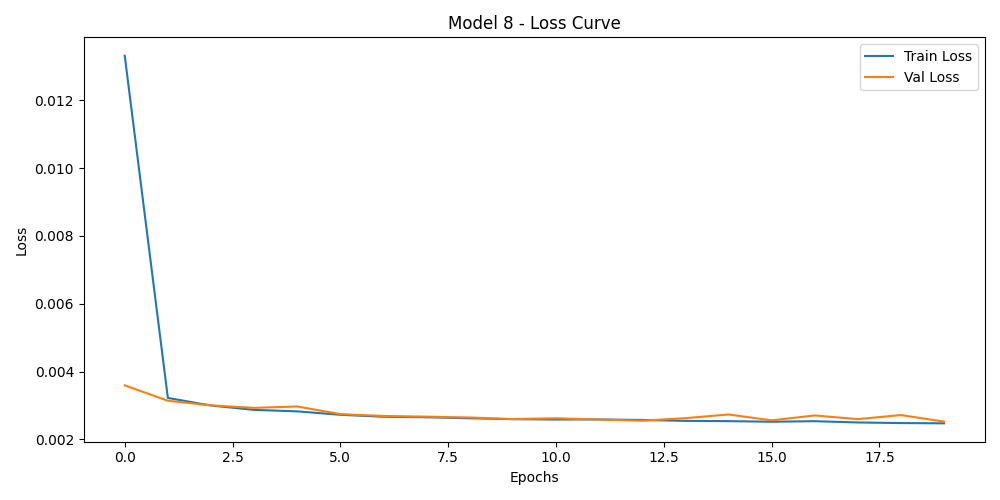

In [5]:
from IPython.display import Image, display

# Set the path to the loss curve image folder
loss_curve_dir = 'LSTM_MME_loss_curve'

# Iterate through all PNG files in the folder
for filename in sorted(os.listdir(loss_curve_dir)):
    if filename.endswith('.png'):
        print(f"Displaying: {filename}")
        display(Image(filename=os.path.join(loss_curve_dir, filename)))

For all six MME models, the training and validation loss curves demonstrate consistent convergence without signs of overfitting or underfitting. Specifically, the validation loss closely follows the training loss across all 20 training epochs, indicating that the models generalize well to unseen data.

**Daily-Scale Test Period Prediction Visualization for All MME Models**

Plotting test prediction for model 3...


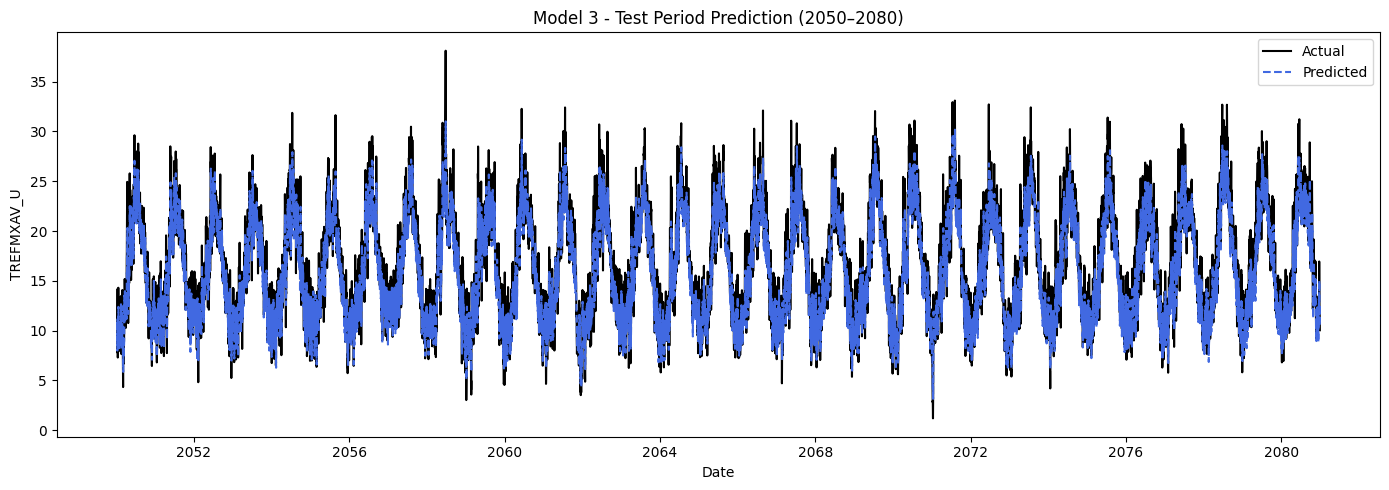

Plotting test prediction for model 4...


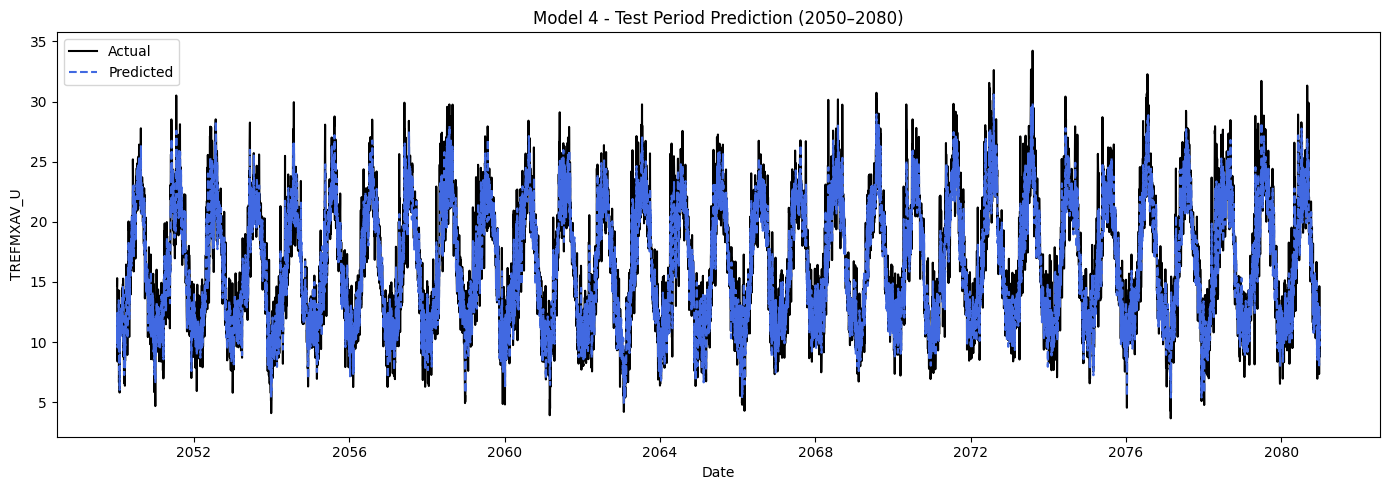

Plotting test prediction for model 5...


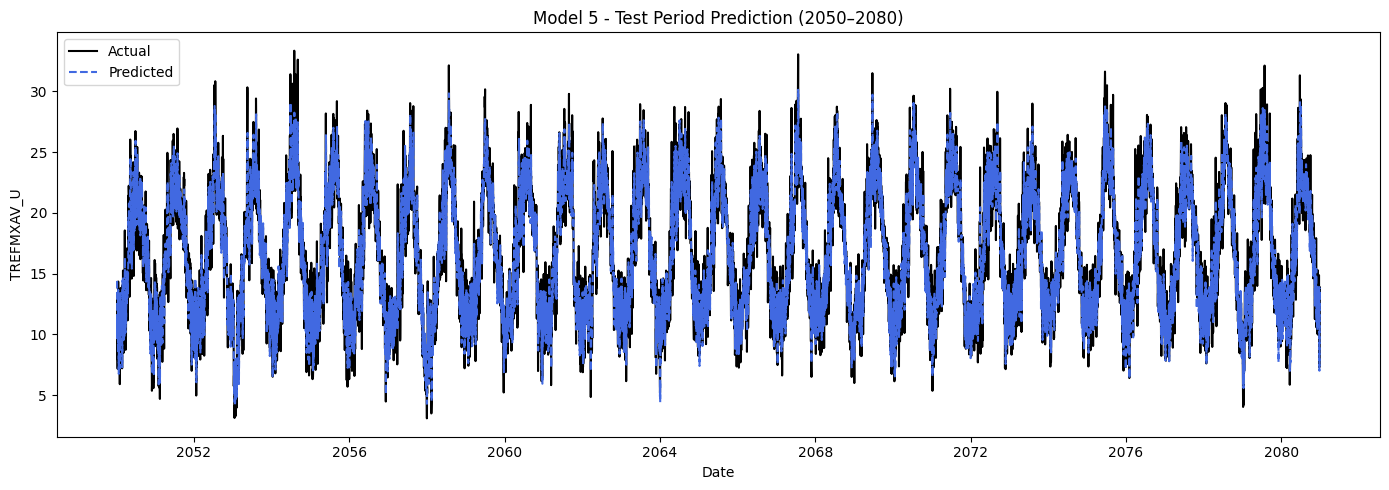

Plotting test prediction for model 6...


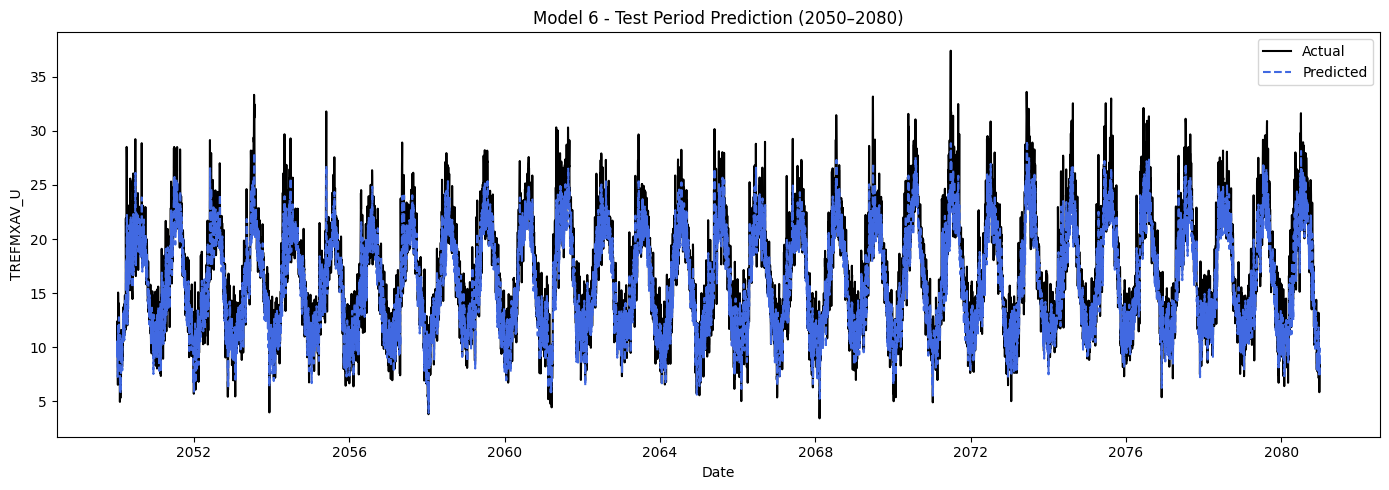

Plotting test prediction for model 7...


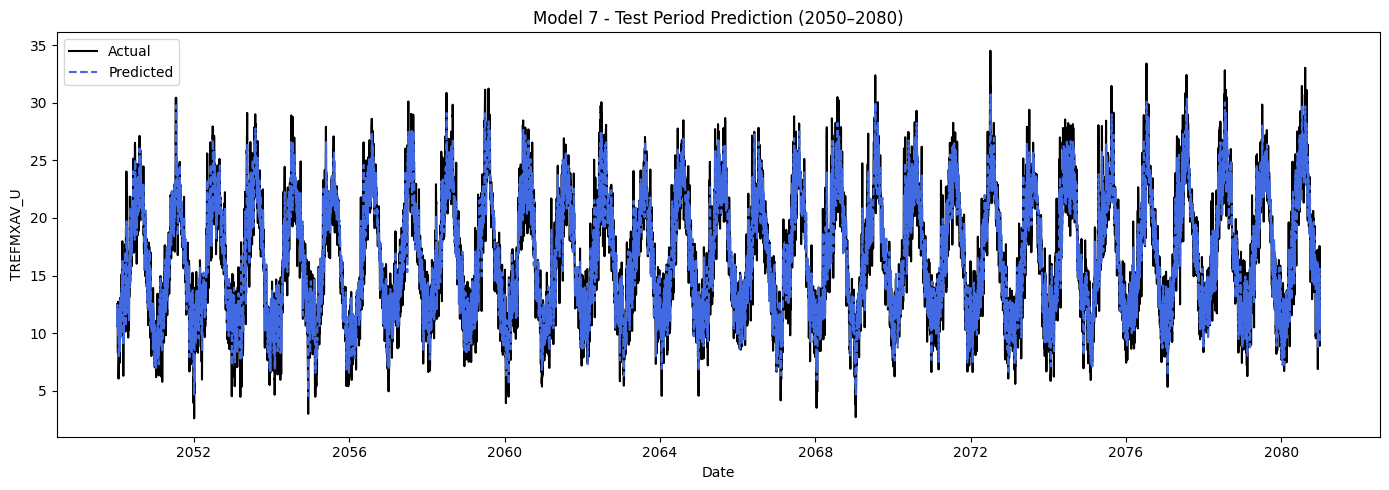

Plotting test prediction for model 8...


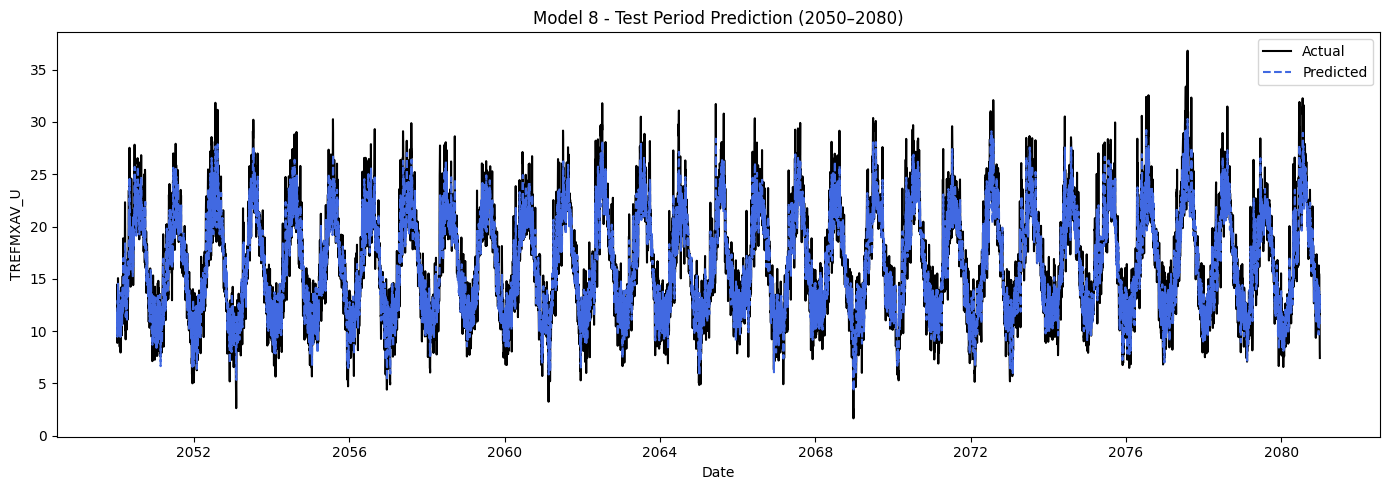

In [6]:
# Create a directory to save the plots
plot_dir = 'LSTM_MME_Test_plot'
os.makedirs(plot_dir, exist_ok=True)

# Loop through models 3–8, read predictions and plot
for model_id in range(3, 9):
    print(f"Plotting test prediction for model {model_id}...")

    # Read test prediction data from the LSTM_MME_prediction folder
    file_path = f'LSTM_MME_prediction/model_{model_id}_test_predictions.csv'
    test_df = pd.read_csv(file_path, parse_dates=['date'])

    # Plot actual vs predicted
    plt.figure(figsize=(14, 5))
    plt.plot(test_df['date'], test_df['Actual'], label='Actual', color='black')
    plt.plot(test_df['date'], test_df['Predicted'], label='Predicted', linestyle='--', color='royalblue')
    plt.title(f'Model {model_id} - Test Period Prediction (2050–2080)')
    plt.xlabel('Date')
    plt.ylabel('TREFMXAV_U')
    plt.legend()
    plt.grid(False)
    plt.tight_layout()

    # Save the plot to the LSTM_MME_Test_plot folder
    plt.savefig(f'{plot_dir}/model_{model_id}_test_plot.png')
    plt.show()

## Application of LSTM to the CHESS Dataset

**Methodology**

The monthly CHESS climate dataset was chronologically divided into training, validation, and testing subsets. Specifically, the training set spans from January 2006 to December 2040, the validation set from January 2041 to December 2049, and the testing set from January 2050 to November 2080. The input sequence length was set to 3 steps, meaning each training sample consists of a rolling sequence of three consecutive time steps of meteorological variables used to predict the target variable at the fourth time step. Only two input features were used: PRECT and FSNS, while the target variable remained TREFMXAV_U.

The model architecture and training configuration were kept consistent with those used for the MME datasets.

After each training iteration, the model was evaluated on the test set. The predicted outputs and actual values were inverse-transformed from the normalized scale for proper comparison. In order to evaluate the learning dynamics, training and validation loss curves were recorded across epochs and visualized as .png plots. These curves confirmed effective convergence, with no signs of overfitting or underfitting observed.

All prediction results—on both the training and test sets—were saved in .csv format within the LSTM_CHESS_prediction/ directory, including the columns for date, actual value, and predicted value. The training loss curves for the CHESS model were saved as .png images in the LSTM_CHESS_loss_curve/ directory, facilitating further visual and quantitative evaluation.


Processing model 85...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Model 85 - Test RMSE: 3.124


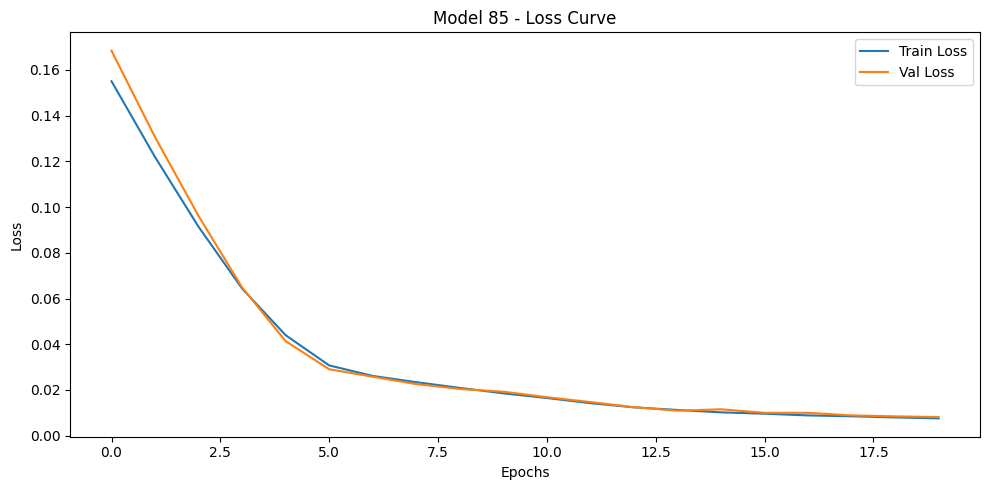

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [7]:
# Ensure the date column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Parameter configuration (for model 85)
model_id = 85
target_variable = 'TREFMXAV_U'
feature_variables = ['PRECT', 'FSNS']
sequence_length = 3

# Create directories for saving predictions and loss curves (if they don’t exist)
prediction_dir = 'LSTM_CHESS_prediction'
loss_dir = 'LSTM_CHESS_loss_curve'
os.makedirs(prediction_dir, exist_ok=True)
os.makedirs(loss_dir, exist_ok=True)

print(f"\nProcessing model {model_id}...")

# Filter model 85 data (without modifying the original df)
df_model = df[df['model'] == model_id].copy()
df_model = df_model[['date'] + feature_variables + [target_variable]].dropna()
df_model = df_model.sort_values('date').set_index('date')

# Scale features and target
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
features_scaled = pd.DataFrame(
    feature_scaler.fit_transform(df_model[feature_variables]),
    columns=feature_variables,
    index=df_model.index
)
target_scaled = pd.DataFrame(
    target_scaler.fit_transform(df_model[[target_variable]]),
    columns=[target_variable],
    index=df_model.index
)
df_scaled = pd.concat([features_scaled, target_scaled], axis=1)

# Split into training, validation, and test sets (by month)
train_df = df_scaled.loc['2006-01':'2040-12']
val_df = df_scaled.loc['2041-01':'2049-12']
test_df = df_scaled.loc['2050-01':'2080-11']

# Create sequences
X_train, y_train, idx_train = create_sequences(train_df, feature_variables, target_variable, sequence_length)
X_val, y_val, _ = create_sequences(val_df, feature_variables, target_variable, sequence_length)
X_test, y_test, idx_test = create_sequences(test_df, feature_variables, target_variable, sequence_length)

# Build the LSTM model
model = Sequential()
model.add(LSTM(20, activation='relu', input_shape=(sequence_length, X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), verbose=0)

# Evaluate on the test set
y_pred = model.predict(X_test)
y_pred_rescaled = target_scaler.inverse_transform(y_pred)
y_test_rescaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"Model {model_id} - Test RMSE: {rmse:.3f}")

# Save loss curve plot
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title(f'Model {model_id} - Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)
plt.tight_layout()
loss_path = os.path.join(loss_dir, f'model_{model_id}_loss_curve.png')
plt.savefig(loss_path)
plt.show()
plt.close()

# Save prediction results (training + test)
save_predictions(X_train, y_train, idx_train, 'train')
save_predictions(X_test, y_test, idx_test, 'test')

**Monthly-Scale Test Period Prediction Visualization for Model 85**

Plotting test prediction for model 85


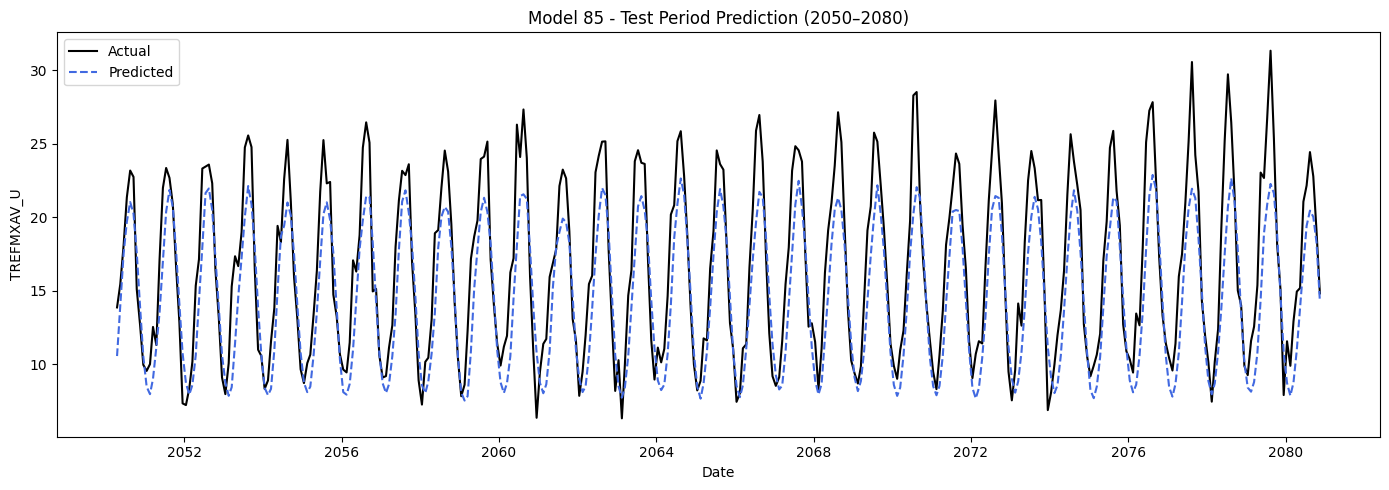

In [8]:
# Create directory to save the plot
plot_dir = 'LSTM_CHESS_Test_plot'
os.makedirs(plot_dir, exist_ok=True)

# Read predictions and plot
print(f"Plotting test prediction for model 85")

# Read test prediction data from the LSTM_CHESS_prediction folder
file_path = f'LSTM_CHESS_prediction/model_{model_id}_test_predictions.csv'
test_df = pd.read_csv(file_path, parse_dates=['date'])

# Plot actual vs predicted
plt.figure(figsize=(14, 5))
plt.plot(test_df['date'], test_df['Actual'], label='Actual', color='black')
plt.plot(test_df['date'], test_df['Predicted'], label='Predicted', linestyle='--', color='royalblue')
plt.title(f'Model {model_id} - Test Period Prediction (2050–2080)')
plt.xlabel('Date')
plt.ylabel('TREFMXAV_U')
plt.legend()
plt.grid(False)
plt.tight_layout()

# Save the plot to the test_plot folder
plt.savefig(f'{plot_dir}/model_{model_id}_test_plot.png')
plt.show()